To choose the columns that you want to change in order to maximize the classification error, you can use a technique called saliency mapping. Saliency mapping involves computing the saliency or importance of each pixel or region in the input image with respect to the output of the CNN.

Here's a general approach you could take:

Choose a sample image from your dataset and feed it through the CNN.

Calculate the gradient of the output of the CNN with respect to the input image.

Compute the saliency map by taking the absolute value of the gradient and normalizing it to have values between 0 and 1.

Identify the columns with the highest saliency values. These are the columns that have the most influence on the CNN's output for the given image.

Select a fraction of the columns with the highest saliency values. For example, if you want to modify 15% of the columns, you could choose the top 15% columns with the highest saliency values.

Apply the adversarial perturbation to the selected columns, as described in my previous answer.

Verify that the modified image causes the CNN to misclassify it.

Note that the specific details of the saliency mapping technique may depend on the architecture of the CNN and the type of input image. You may need to experiment with different saliency mapping algorithms or tweak the parameters to achieve the desired level of column selection.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unrar x /content/drive/MyDrive/HomeAssigment4.rar

Streaming output truncated to the last 5000 lines.
Extracting  train_spec/go/645.png                                         92%  OK 
Extracting  train_spec/go/646.png                                         92%  OK 
Extracting  train_spec/go/647.png                                         92%  OK 
Extracting  train_spec/go/648.png                                         92%  OK 
Extracting  train_spec/go/649.png                                         92%  OK 
Extracting  train_spec/go/65.png                                          92%  OK 
Extracting  train_spec/go/650.png                                         92%  OK 
Extracting  train_spec/go/651.png                                         92%  OK 
Extracting  train_spec/go/652.png                                         92%  OK 
Extracting  train_spec/go/653.png                                         92%  OK 
Extracting  train_spec/go/654

In [ ]:
!unzip image_test_audio.zip

unzip:  cannot find or open image_test_audio.zip, image_test_audio.zip.zip or image_test_audio.zip.ZIP.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import thinkdsp as tp
import numpy as np
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
model = keras.models.load_model('my_model')

In [ ]:
IMAGE_SHAPE = (369, 496)
VALID_DATA_DIR = 'test_spec/' # replace with your generated test set in here
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
    batch_size=1
)

Found 1600 images belonging to 8 classes.


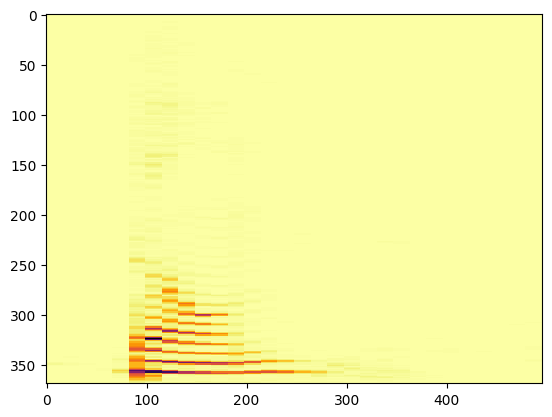

[[1. 0. 0. 0. 0. 0. 0. 0.]] (369, 496, 3)


In [ ]:
plt.imshow(valid_generator[0][0][0])
plt.show()
print(valid_generator[0][1],valid_generator[0][0][0].shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.pyplot as plt
y_pred= []
X_test= []
y_test= []
for i in range(len(valid_generator)):
  batch = valid_generator.next()
  X_test.append(batch[0])
  y_test.append(batch[1])


KeyboardInterrupt: ignored

eps = 0.000000014
threshold 1

0.001 good one with accurcy  [1.4599665403366089, 0.53125]

In [ ]:
def fgsm(model, x, y_true, eps):
    x = tf.identity(x)
    
    # Compute the gradient of the loss with respect to the input image
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        loss = loss_object(y_true, y_pred)

    gradient = tape.gradient(loss, x)
    saliency_map = tf.reduce_max(tf.abs(gradient), axis=-1)

    # Select columns with the highest saliency values
    num_cols = x.shape[2]
    num_cols_to_modify = int(num_cols * 0.20)  # Select top 15% columns to modify
    saliency_flat = tf.reshape(saliency_map, [-1])
    top_indices = tf.argsort(saliency_flat, direction='DESCENDING')[:num_cols_to_modify]
    col_indices = top_indices % num_cols  # Convert 1D index to (row, col) index
    col_indices = tf.sort(col_indices).numpy()  # Sort column indices in ascending order
    
    # Calculate the sign of the gradient
    sign_gradient = tf.sign(gradient)
    sign_gradient = sign_gradient.numpy()
    
    # Create the perturbed image by adding the scaled sign gradient to the original image
    perturbed_x = x.numpy()
    perturbed_x[:, :, col_indices, :] +=  eps * sign_gradient[:, :, col_indices, :]
    
    # Clip the pixel values of the perturbed image to ensure they remain within the valid range
    perturbed_x = tf.clip_by_value(perturbed_x, 0, 1)
    perturbed_x = perturbed_x.numpy()
    
    return perturbed_x

In [8]:
def check_change_percentage(x,y):
  """This function to show the difference column percentage"""
  diff = np.abs(x - y)
  columns_diff = np.sum(diff, axis=(0,1,3))
  columns_diff = np.count_nonzero(columns_diff)
  return columns_diff*100/496

In [ ]:
X_adv= []
all= 369*496*3
eps = 1
diff_precentages=[]
for i in range(len(X_test)):

  #Make the attack
  x_adv = fgsm(model, X_test[i], y_test[i] ,eps)
  X_adv.append(x_adv)

  #Calculate the percentage
  diff_precentage = check_change_percentage(x_adv,X_test[i])
  diff_precentages.append(diff_precentage)
  
  #Check the percentages that exceed 15%
  if diff_precentage > 14:
    print(f"Sample {i}: has changed with percentage {diff_precentage}")

  if i%100==0:
    print(f"{i} Sample changed")

The change pecentage distubution between samaples
As you see it does not exceed 15 percent 

In [ ]:
plt.hist(diff_precentages)

plot random spectogram, you can see that the percentage of the change does not exceed 15%

In [ ]:
plt.imshow(X_adv[9][0])
plt.show()

the percentage of changed pixels for the first sample

In [ ]:
all= 369*496*3
diff_count = np.count_nonzero(np.not_equal(X_adv[9], X_test[9]))
print("Number of pixels changed",diff_count)
print("pecentage of pixels changed",100*diff_count/all)

Make the directory

In [ ]:
!rm -r /content/y_test_dir2

In [ ]:
test_dir_name=['down','go','left','no','right','stop','up','yes']
import os
import shutil
y_test_dir = 'y_test_dir2'
y_pred_audio = 'y_pred_audio'
if not os.path.exists(y_test_dir):
    os.makedirs(y_test_dir)
for i in range(8):
  if not os.path.exists(f"{y_test_dir}/{test_dir_name[i]}"):
    os.makedirs(f"{y_test_dir}/{test_dir_name[i]}")
  if not os.path.exists(f"{y_pred_audio}/{test_dir_name[i]}"):
    os.makedirs(f"{y_pred_audio}/{test_dir_name[i]}")

for i, img in enumerate(X_adv):
    print(i)
    img_path = os.path.join(f"{y_test_dir}/{test_dir_name[list(y_test[i][0]).index(1)]}", f"{i%200}.png")
    Path_audio = os.path.join(f"{y_pred_audio}/{test_dir_name[list(y_test[i][0]).index(1)]}", f"{i%200}.wav")
    plt.imsave(img_path, img[0])
    
   
# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create a DirectoryIterator
batch_size = 32
test_iterator1 = datagen.flow_from_directory(
    y_test_dir,
    target_size=IMAGE_SHAPE,
    shuffle=False,
    batch_size=32
)

In [ ]:
model.evaluate(test_iterator1)

In [ ]:
"""import librosa
import numpy as np
from PIL import Image
from scipy.signal import invert_spectrogram
import soundfile as sf
import thinkdsp
import scipy.io.wavfile as wavfile
def convert_spectogram_to_Audio(Path_spec,Path_audio):

  image = Image.open(Path_spec)
  data = np.array(img)
  spectrogram = thinkdsp.Spectrogram(data)
  audio = invert_spectrogram(spectrogram.specMap, spectrogram.fs, spectrogram.ts)
  #image = image.convert('L')
  #data = np.asarray(image)
  audio = invert_spectrogram(spectrogram.specMap, spectrogram.fs, spectrogram.ts)
  audio_norm = audio / np.max(np.abs(audio))
  signal = thinkdsp.invert_spectrogram(data)
  framerate = 44100
  # save the audio signal to a WAV file
  wavfile.write(Path_audio, framerate, signal)"""

In [ ]:
from IPython.display import Audio

# Load the WAV file and play it
Audio('/content/test_audio/down/cd7f8c1b_nohash_0.wav')

In [ ]:
from thinkdsp import read_wave

wave = read_wave('/content/test_audio/down/cd7f8c1b_nohash_0.wav')

In [ ]:
spectrogram = wave.make_spectrogram(seg_length=1024)

In [ ]:
"""import os
import thinkdsp as tp
import numpy as np
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt


parent_dir = "test_audio"

file_paths = []

for root, dirs, files in os.walk(parent_dir):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path[:-4])"""

In [ ]:
"""file_paths[:10]"""

In [ ]:
"""test_dir_name=['down','go','left','no','right','stop','up','yes']
y_test_dir = 'image_test_audio'
if not os.path.exists(y_test_dir):
    os.makedirs(y_test_dir)
for i in range(8):
  if not os.path.exists(f"{y_test_dir}/{test_dir_name[i]}"):
    os.makedirs(f"{y_test_dir}/{test_dir_name[i]}")"""

In [ ]:
"""print(len(file_paths))"""

In [ ]:
"""for i in range(1550,len(file_paths)):
    print(i)
    wave = tp.read_wave(f"{file_paths[i]}.wav")
    spectrogram = wave.make_spectrogram(seg_length=1024)
    spectrogram.plot(high=5000)
    plt.axis('off')
    plt.savefig(f'image_{file_paths[i]}.png', bbox_inches='tight', pad_inches=0)"""

In [ ]:
#!zip -r ./image_test_audio.zip ./image_test_audio

In [9]:
audio_dir_name=['down','go','left','no','right','stop','up','yes']
audio_dir='test_audio/'
X_audio=[]
for i in range(8):
  file_list = os.listdir(f"{audio_dir}{audio_dir_name[i]}")
  for j in file_list:
    wave1 = tp.read_wave(f"{audio_dir}{audio_dir_name[i]}/{j}")
    X_audio.append(wave1)

In [10]:
len(X_audio)

1599

In [11]:
IMAGE_SHAPE = (369, 496)
VALID_DATA_DIR = '/content/test_spec' # replace with your generated test set in here
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator1 = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
    batch_size=1,
)

Found 1600 images belonging to 8 classes.


In [ ]:
model.evaluate(valid_generator1)

(0.01596875, 0.97596875, -7.8125, 4992.1875)

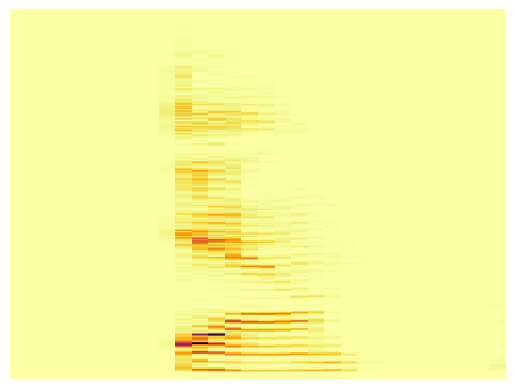

In [23]:
specto= X_audio[3].make_spectrogram(seg_length=1024)
specto.plot(high=5000)
plt.axis('off')

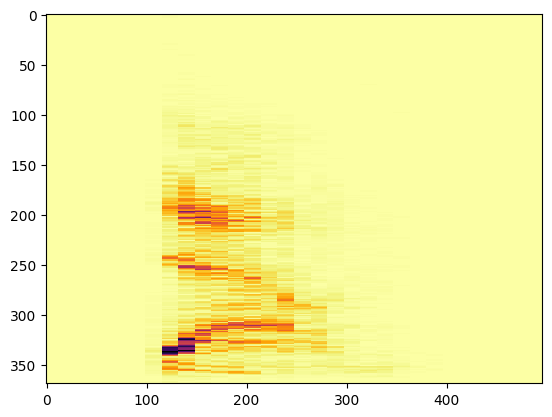

In [22]:
plt.imshow(valid_generator1[3][0][0])
plt.show()

In [14]:
print(valid_generator1[0][1])

[[1. 0. 0. 0. 0. 0. 0. 0.]]


In [29]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.pyplot as plt
y_pred= []
X_test= []
y_test= []
wave_list = []
for i in range(len(valid_generator1)):
  batch = valid_generator1.next()
  X_test.append(batch[0])
  y_test.append(batch[1])


In [30]:
import random
# Combine the lists into a list of tuples
combined_list = list(zip(X_audio, X_test, y_test))

# Shuffle the list of tuples
random.shuffle(combined_list)

# Unzip the shuffled list of tuples back into three separate lists
X_audio1, X_test1, y_test1 = zip(*combined_list)

X_audio=X_audio1[:300]
X_test=X_test1[:300]
y_test=y_test1[:300]

In [31]:
def fgsm(model, x, y_true, eps):
    x = tf.identity(x)
    
    # Compute the gradient of the loss with respect to the input image
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        loss = loss_object(y_true, y_pred)

    gradient = tape.gradient(loss, x)
    saliency_map = tf.reduce_max(tf.abs(gradient), axis=-1)

    # Select columns with the highest saliency values
    num_cols = x.shape[2]
    num_cols_to_modify = int(num_cols * 0.20)  # Select top 15% columns to modify
    saliency_flat = tf.reshape(saliency_map, [-1])
    top_indices = tf.argsort(saliency_flat, direction='DESCENDING')[:num_cols_to_modify]
    col_indices = top_indices % num_cols  # Convert 1D index to (row, col) index
    col_indices = tf.sort(col_indices).numpy()  # Sort column indices in ascending order
    
    # Calculate the sign of the gradient
    sign_gradient = tf.sign(gradient)
    sign_gradient = sign_gradient.numpy()
    
    # Create the perturbed image by adding the scaled sign gradient to the original image
    perturbed_x = x.numpy()
    perturbed_x[:, :, col_indices, :] +=  eps * sign_gradient[:, :, col_indices, :]
    
    # Clip the pixel values of the perturbed image to ensure they remain within the valid range
    perturbed_x = tf.clip_by_value(perturbed_x, 0, 1)
    perturbed_x = perturbed_x.numpy()
    
    return perturbed_x , col_indices

In [32]:
sampling_rate = X_audio[0].framerate
sampling_rate

16000

In [33]:
X_adv= []
columns_lists = []
time_lists=[]
all= 369*496*3
eps = 1
diff_precentages=[]
for i in range(len(X_test)):

  #Make the attack
  x_adv , col_list = fgsm(model, X_test[i], y_test[i] ,eps)
  times = [index / 16000 for index in col_list]
  times = list(set(times))
  X_adv.append(x_adv)
  columns_lists.append(col_list)
  time_lists.append(times)
  
  #Calculate the percentage
  diff_precentage = check_change_percentage(x_adv,X_test[i])
  diff_precentages.append(diff_precentage)
  
  #Check the percentages that exceed 15%
  if diff_precentage > 14:
    print(f"Sample {i}: has changed with percentage {diff_precentage}")

  if i%100==0:
    print(f"{i} Sample changed")

0 Sample changed
100 Sample changed
200 Sample changed
Sample 248: has changed with percentage 14.314516129032258


In [34]:
Time =[]
for i in  time_lists[0]:
  Time.append(i*16000)
print(sorted(time_lists[0]))
print(sorted(Time))

[0.0154375, 0.0155, 0.015625, 0.01575, 0.0165625, 0.016625, 0.01675, 0.01775, 0.017875, 0.018, 0.01875, 0.018875, 0.019125, 0.01975, 0.019875, 0.02, 0.02025, 0.02075, 0.020875, 0.021, 0.0216875, 0.02175, 0.0218125, 0.021875, 0.022, 0.0220625, 0.022375, 0.0225, 0.02275, 0.0228125, 0.022875, 0.023, 0.0230625, 0.023125, 0.02325, 0.0233125, 0.023375, 0.0235, 0.023875, 0.024, 0.024125, 0.024375, 0.0245, 0.0246875, 0.027875, 0.028, 0.02875, 0.0288125, 0.0289375, 0.029, 0.0290625, 0.029125, 0.02925, 0.0295]
[247.0, 248.0, 250.0, 252.0, 265.0, 266.0, 268.0, 284.0, 286.0, 288.0, 300.0, 302.0, 306.0, 316.0, 318.0, 320.0, 324.0, 332.0, 334.0, 336.0, 347.0, 348.0, 349.0, 350.0, 352.0, 353.0, 358.0, 360.0, 364.0, 365.0, 366.0, 368.0, 369.0, 370.0, 372.0, 373.0, 374.0, 376.0, 382.0, 384.0, 386.0, 390.0, 392.0, 395.0, 446.0, 448.0, 460.0, 461.0, 463.0, 464.0, 465.0, 466.0, 468.0, 472.0]


In [35]:
def apply_silance(wave,start,end):
  # calculate the sample indices of the segment to silence
  start_index = int(start * wave.framerate)
  end_index = int(end * wave.framerate)
  # truncate the waveform to the desired segment
  segment1 = wave.segment(0, start)
  segment = wave.segment(start, end)
  
  # create a silence waveform with the same duration and framerate as the segment
  duration = end - start
  silence = tp.Wave(np.zeros(int(duration * wave.framerate)), framerate=wave.framerate)
  
  # concatenate the segment and silence waveforms
  silenced_wave = segment1 | silence
  
  # append any remaining portion of the original waveform
  if end < wave.duration:
      remaining = wave.segment(end, wave.duration)
      silenced_wave = silenced_wave | remaining
  return silenced_wave

(0.01596875, 0.97596875, -7.8125, 4992.1875)

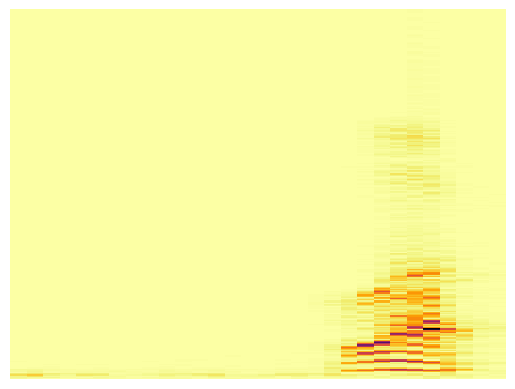

In [38]:
wave1 = X_audio[0].copy()
spectrogram1 = wave1.make_spectrogram(seg_length=1024)
spectrogram1.plot(high=5000)
plt.axis('off')

In [39]:
count = 0
for i in range(len(time_lists[0])):
  start = time_lists[0][i]
  end = start +  1 /16000
  count += end-start
  wave1 = apply_silance(wave1,start,end)
print(int((count*16000)*100/496),"Precentage of changing")

10 Precentage of changing


(0.01596875, 0.97596875, -7.8125, 4992.1875)

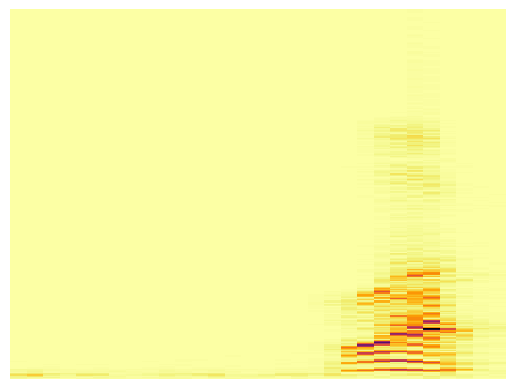

In [40]:
spectrogram1 = wave1.make_spectrogram(seg_length=1024)
spectrogram1.plot(high=5000)
plt.axis('off')

In [46]:
mod_wave=[]
for j in range(len(X_audio)):
  count = 0
  wave1 = X_audio[j].copy()
  for i in range(len(time_lists[j])):
    start = time_lists[j][i]
    end = start +  1 /16000
    count += end-start
    wave1 = apply_silance(wave1,start,end)
  if int((count*16000)*100/496) > 15:
    print(int((count*16000)*100/496),"Precentage of changing")
  mod_wave.append(wave1)

In [47]:
final_spec=[]
for i in range(len(mod_wave)):
  wave1 = mod_wave[i]
  spectrogram = wave1.make_spectrogram(seg_length=1024)
  final_spec.append(spectrogram)

In [43]:
!rm -r /content/y_test_dir3

rm: cannot remove '/content/y_test_dir3': No such file or directory


In [44]:
test_dir_name=['down','go','left','no','right','stop','up','yes']
import os
import shutil
y_test_dir = 'y_test_dir3'
if not os.path.exists(y_test_dir):
    os.makedirs(y_test_dir)
for i in range(8):
  if not os.path.exists(f"{y_test_dir}/{test_dir_name[i]}"):
    os.makedirs(f"{y_test_dir}/{test_dir_name[i]}")


   

In [48]:
len(final_spec)

300

250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299


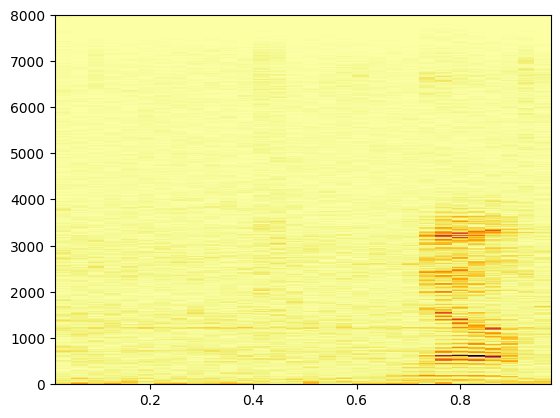

In [56]:
for i in range(250,300):
    print(i)
    img_path = os.path.join(f"{y_test_dir}/{test_dir_name[list(y_test[i][0]).index(1)]}", f"{i%200}.png")
    img = final_spec[i]
    img.plot()
    plt.savefig(img_path)

In [57]:

# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create a DirectoryIterator
batch_size = 32
test_iterator2 = datagen.flow_from_directory(
    y_test_dir,
    target_size=IMAGE_SHAPE,
    shuffle=False,
    batch_size=32
)

Found 290 images belonging to 8 classes.


In [58]:
model.evaluate(test_iterator2)

10/10 [==============================] - 18s 2s/step - loss: 15.4839 - accuracy: 0.1276


[15.483882904052734, 0.12758620083332062]